tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


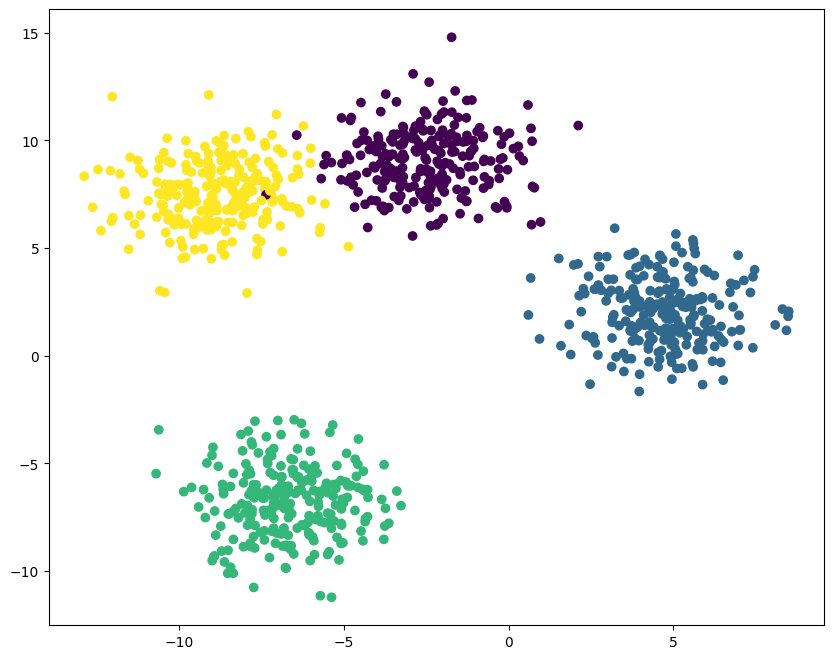

In [17]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

x_blob, y_blob = make_blobs(
    n_features=NUM_FEATURES,
    random_state=RANDOM_SEED,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    n_samples=1000
)

x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)
print(x_blob[:5], y_blob[:5])

x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(
    x_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 8))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_size = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_size),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.Linear(in_features=hidden_size, out_features=out_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model = BlobModel(
    in_features=NUM_FEATURES,
    out_features=NUM_CLASSES,
    hidden_size=8
).to(device)
model


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [21]:
def accuracy_fn(y_pred, y_true):
    res = torch.eq(y_pred.squeeze(), y_true.squeeze()).sum().item()
    return res / torch.numel(y_pred)

tensor1 = torch.round(torch.randn(size=(3, 4)))
tensor2 = torch.round(torch.randn(size=(3, 4)))

res = accuracy_fn(tensor1, tensor2)
res

0.25

In [22]:
torch.manual_seed(42)
epochs = 100

x_blob_train, x_blob_test = x_blob_train.to(device), x_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model.train()
    
    y_logits = model(x_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_pred=y_pred, y_true=y_blob_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        test_logits = model(x_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(test_pred, y_blob_test)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04324, Acc: 0.66% | Test Loss: 0.57861, Test Acc: 0.95%
Epoch: 10 | Loss: 0.14398, Acc: 0.99% | Test Loss: 0.13037, Test Acc: 0.99%
Epoch: 20 | Loss: 0.08062, Acc: 0.99% | Test Loss: 0.07216, Test Acc: 0.99%
Epoch: 30 | Loss: 0.05924, Acc: 0.99% | Test Loss: 0.05133, Test Acc: 0.99%
Epoch: 40 | Loss: 0.04892, Acc: 0.99% | Test Loss: 0.04098, Test Acc: 0.99%
Epoch: 50 | Loss: 0.04295, Acc: 0.99% | Test Loss: 0.03486, Test Acc: 0.99%
Epoch: 60 | Loss: 0.03910, Acc: 0.99% | Test Loss: 0.03083, Test Acc: 0.99%
Epoch: 70 | Loss: 0.03643, Acc: 0.99% | Test Loss: 0.02799, Test Acc: 0.99%
Epoch: 80 | Loss: 0.03448, Acc: 0.99% | Test Loss: 0.02587, Test Acc: 0.99%
Epoch: 90 | Loss: 0.03300, Acc: 0.99% | Test Loss: 0.02423, Test Acc: 0.99%


In [23]:
model.eval()
with torch.inference_mode():
    test_logits = model(x_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    acc = accuracy_fn(test_preds, y_blob_test)
acc

0.995